How to apply tket's compilation to qnode in PennyLane?
[P] qnode -> tape -> [T] circuit -> compilation

In [35]:
import pennylane as qml
from pytket.extensions.pennylane import pennylane_to_tk
from pytket.circuit import Circuit, QubitRegister, BitRegister, OpType
from pytket.passes import (
    DecomposeBoxes,
    RemoveRedundancies,
    SimplifyInitial,
    FullPeepholeOptimise,
    SynthesiseTket,
    RebaseCustom
)
import pandas as pd
from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.qiskit import tk_to_qiskit

In [26]:
[ds] = qml.data.load("ketgpt")

In [36]:
# qnode
seed = 0
@qml.qnode(qml.device('default.qubit'))
def circuit():
    for op in ds.circuits[seed]:
        if op.name == 'QubitUnitary': # exclude unitary gates
            continue
        qml.apply(op)
    return qml.state()

# extract tape from qnode
qfunc = circuit.func
with qml.tape.QuantumTape() as tape:
    qfunc()

In [37]:
# create a corresponding tket circuit with tape
n_qubits = qml.specs(circuit)()['resources'].num_wires
qreg = QubitRegister("q", n_qubits) 
creg = BitRegister("c", 0)     
wire_map = {w: i for i, w in enumerate(tape.wires)}
tk_circ = pennylane_to_tk(tape.operations, wire_map, qreg, creg)

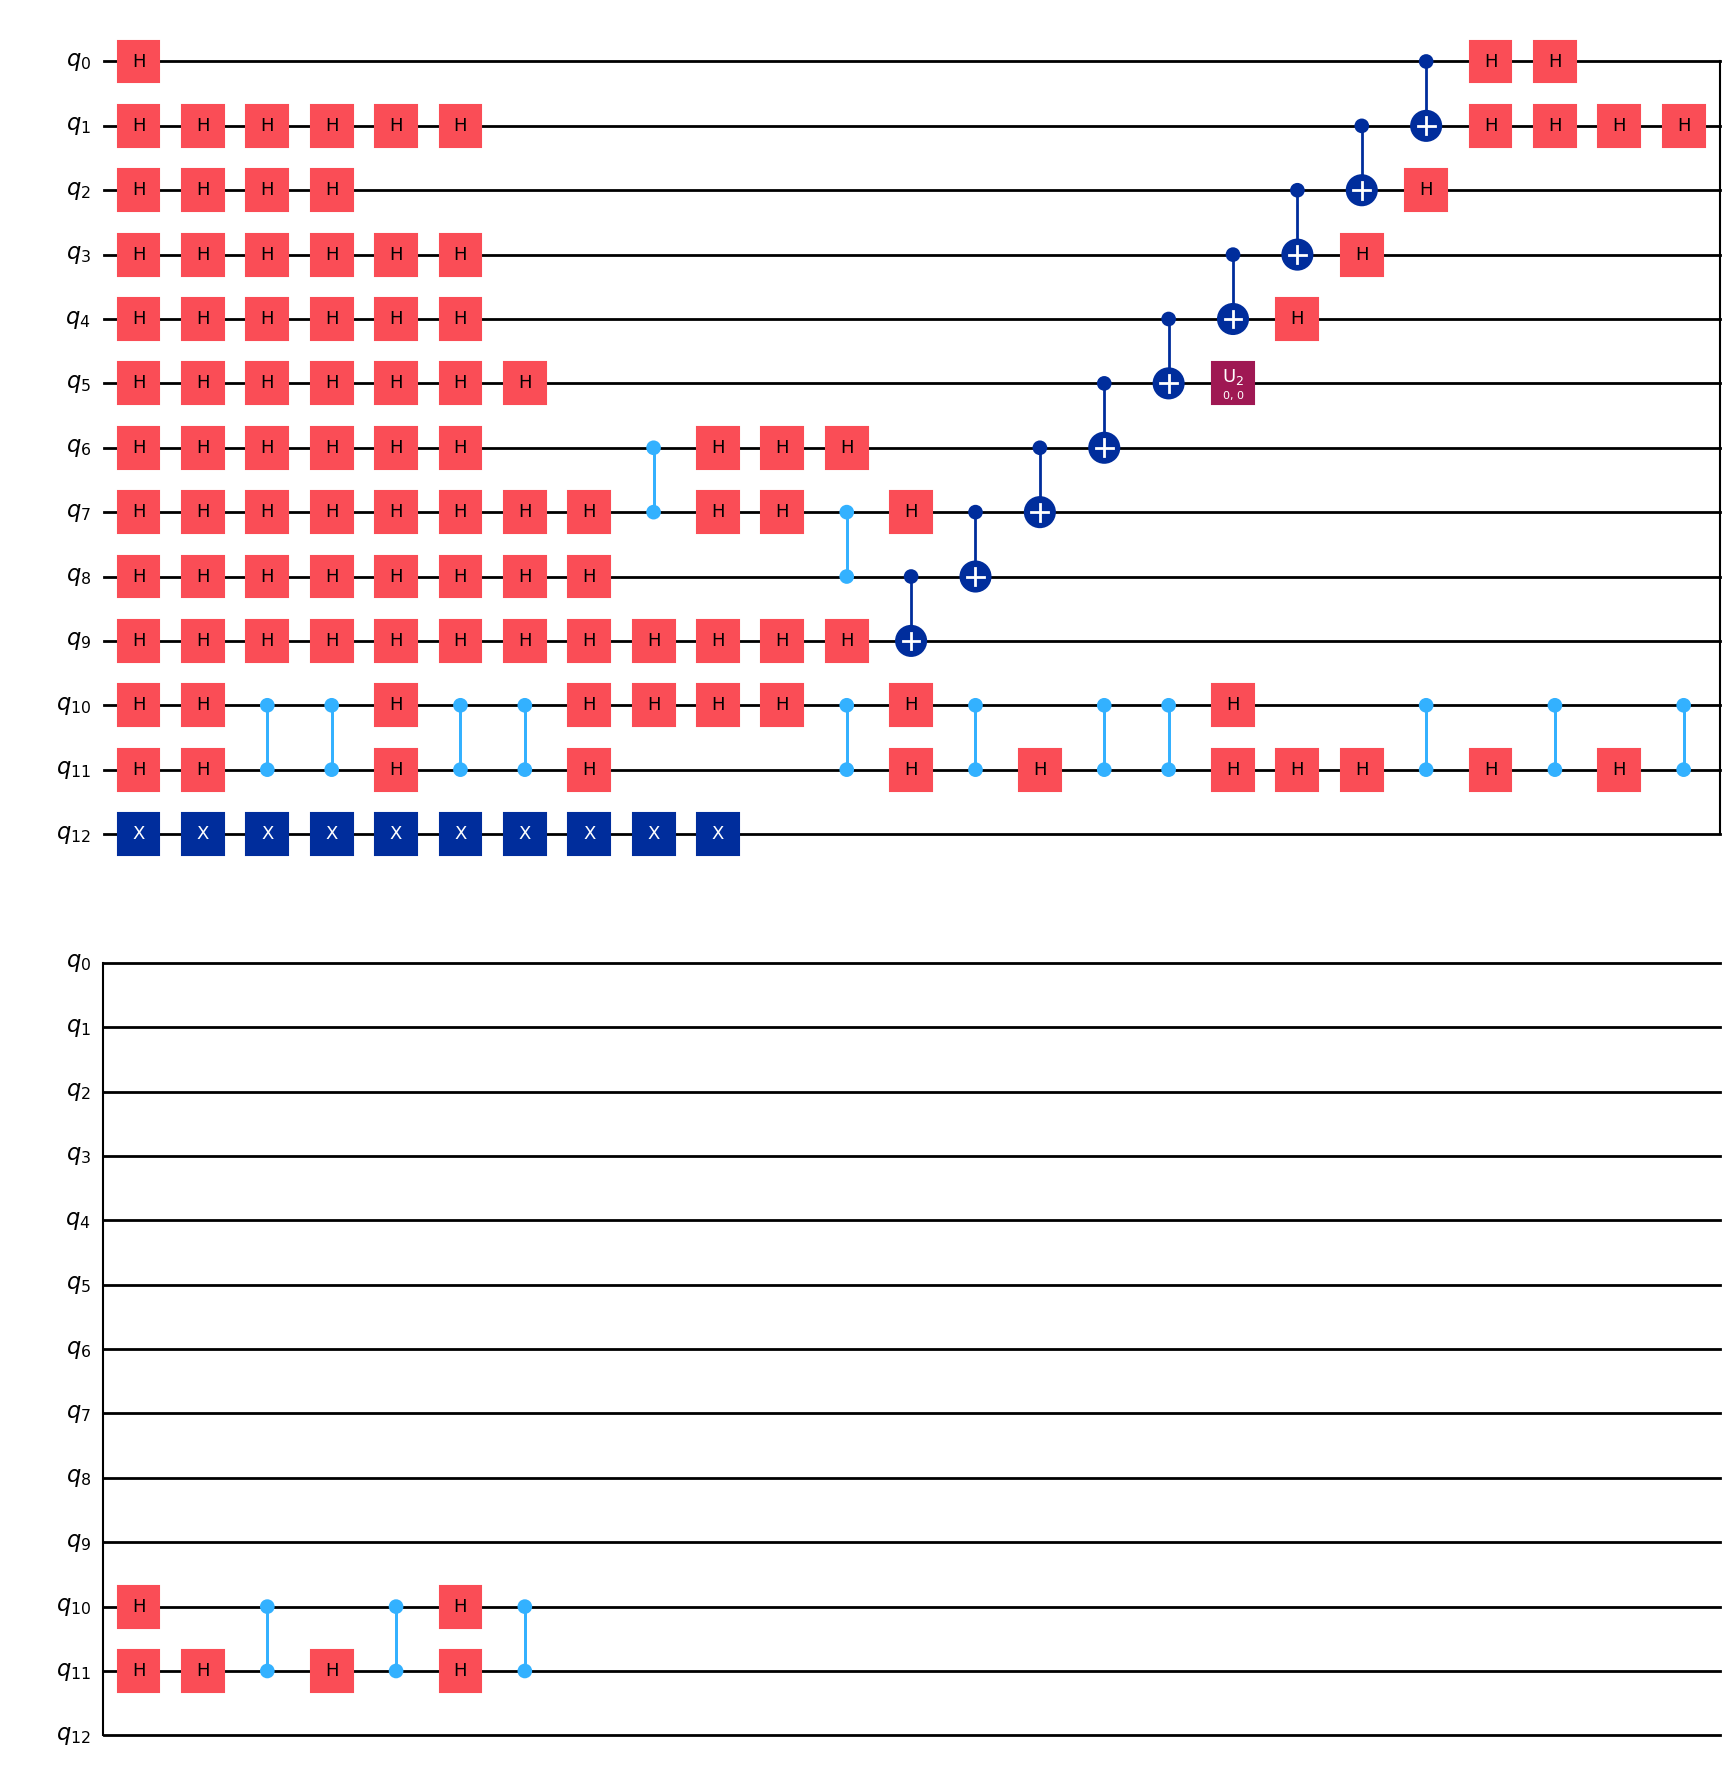

In [ ]:
# live visualization - invisible in GitHub
render_circuit_jupyter(tk_circ)

# visualization through qiskit
qiskit_circ = tk_to_qiskit(tk_circ)
qiskit_circ.draw("mpl")

In [39]:
# print specifications of tk_circ
def spec_tket(tk_circ):
    total_gates = tk_circ.n_gates
    single_qubit_ops = [OpType.H, OpType.X, OpType.Ry, OpType.Rz]
    single_qubit_count = sum(tk_circ.n_gates_of_type(op) for op in single_qubit_ops)
    two_qubit_ops = [OpType.CX, OpType.CZ]
    two_qubit_count = sum(tk_circ.n_gates_of_type(op) for op in two_qubit_ops)
    depth = tk_circ.depth()
    return [total_gates, single_qubit_count, two_qubit_count, depth]

df = pd.DataFrame(spec_tket(tk_circ), columns=['tket'], index=['gate count','single-q gate count','two-q gate count','depth'])
df

,tket
gate count,141
single-q gate count,115
two-q gate count,25
depth,32


For details of the circuit class in Tket, see 
<a href="https://docs.quantinuum.com/tket/api-docs/optype.html">pytket API doc: pytket.circuit.OpType</a>.

In [40]:
# note how to call different gate types!
basis = {OpType.H, OpType.X, OpType.Ry, OpType.Rz, OpType.CX, OpType.CZ}

# Replacement for CX (just a CX gate) - required line for basis customization
cx_replacement = Circuit(2).CX(0, 1)

# unitary synthesis for single-qubit gates, 
# otherwise you will get OpType.TK1 (:=Rz(a)Ry(b)RZ(c), same as qml.U3)
def tk1_to_rzryrz(a, b, c):
    circ = Circuit(1)
    circ.Rz(a, 0)
    circ.Ry(b, 0)
    circ.Rz(c, 0)
    return circ

custom_rebase = RebaseCustom(basis, cx_replacement, tk1_to_rzryrz) # 
pipeline = [
    DecomposeBoxes(),
    RemoveRedundancies(),
    SimplifyInitial(),
    FullPeepholeOptimise(),
    SynthesiseTket(),
    custom_rebase # 
]

for pass_ in pipeline:
    pass_.apply(tk_circ) # automatically updated 

df['tket_compiled'] = spec_tket(tk_circ)
df

,tket,tket_compiled
gate count,141,44
single-q gate count,115,33
two-q gate count,25,11
depth,32,15


c:\Users\syj43\AppData\Local\Programs\Python\Python310\lib\site-packages\pytket\extensions\qiskit\qiskit_convert.py:1158: UserWarning: The pytket Circuit contains implicit qubit permutations which aren't handled by default. Consider using the replace_implicit_swaps flag in tk_to_qiskit or replacing them using Circuit.replace_implicit_wire_swaps().
  warnings.warn(  # noqa: B028


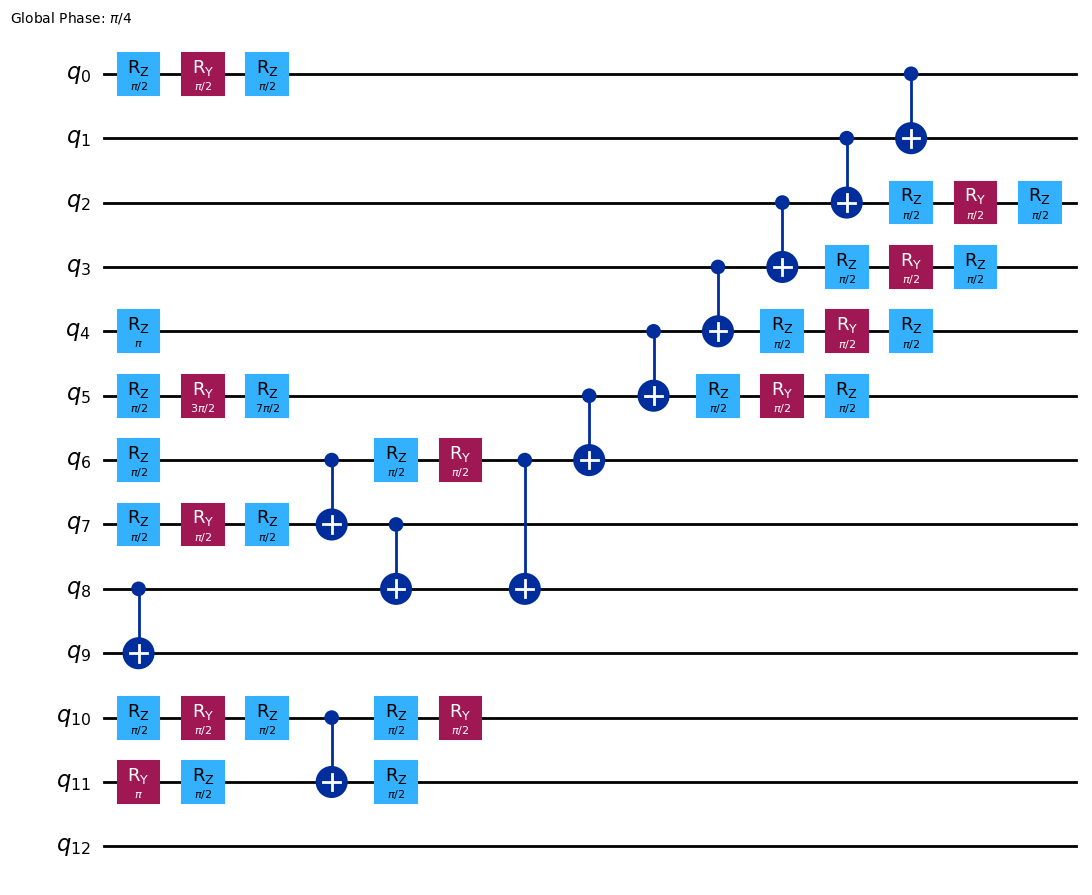

In [41]:
# visualization - invisible in GitHub
render_circuit_jupyter(tk_circ)

# visualization through qiskit
qiskit_circ = tk_to_qiskit(tk_circ)
qiskit_circ.draw("mpl")

Note that tket represent the circuit with three gates RX, RY, and CNOT!